# Models Comparison for TinyML

In [14]:
# Load libraries
import numpy as np
from numpy import arange
import pickle

#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import sys
import seaborn as sbs

warnings.filterwarnings('ignore')

In [15]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)

## Change 'chosenIndex' to change the chosen Test (s/s3/s6)

In [16]:
dataXPath = ['../data/X.pkl', '../data/XS3.pkl', '../data/XS6.pkl']
dataYPath = ['../data/y.pkl', '../data/yS3.pkl', '../data/yS6.pkl']
choosenIndex = 0

with open(dataXPath[choosenIndex], 'rb') as f:
    X = pickle.load(f)

with open(dataYPath[choosenIndex], 'rb') as f:
    y = pickle.load(f)

In [17]:
print(np.unique(y))

[ 500 1000 1500 2000 2500 3000]


In [18]:
# Convert the labels in values like 0...n for the NN tests

labels = []
uniques = list(np.unique(y))

[labels.append(uniques.index(el)) for el in y]

y = np.array(labels)
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

In [20]:
print(y_test.shape)

(120,)


## Model Spotting

In [21]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [22]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.05, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [23]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,99 0,01
LR - 0,37 0,05
CART - 0,99 0,01
SVC - 0,19 0,04
RF - 0,99 0,01


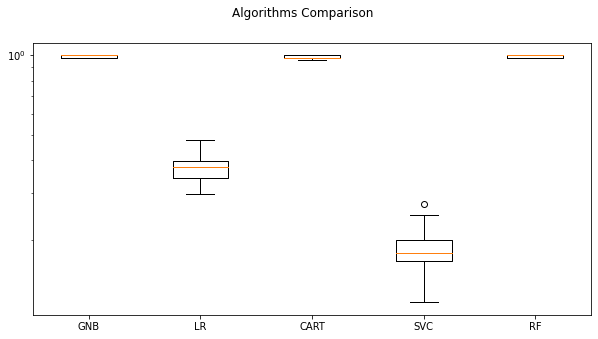

In [24]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_yscale('log')
ax.set_xticklabels(names)
plt.show()

# Valutazione dei modelli sul Test Set

In [25]:
tasks = ['S', 'S3', 'S6']
def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = uniques[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[choosenIndex]+ '/classificationReports/'+'classification_report' + model_name +  '.csv', index = False)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      0.95      0.97        20
           5       0.95      1.00      0.98        20

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.47      0.35      0.40        20
           1       0.27      0.20      0.23        20
           2       0.53      0.50      0.51        20
           3       0.27      0.20      0.23        20
           4       0.43      0.45      0.44        20
           5       0.43      0.75      0.55    

# Valutazione Inferance Rate medio (|X_test| = 50/50/100)

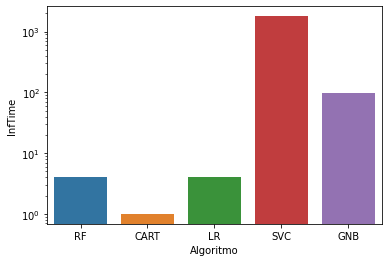

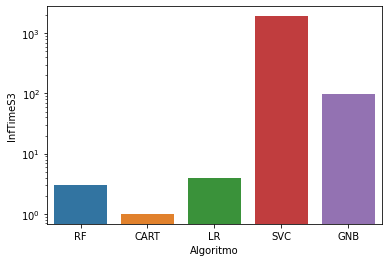

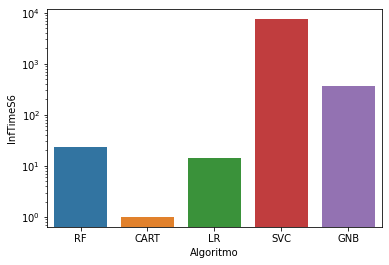

In [26]:
columns = ['InfTime', 'InfTimeS3', 'InfTimeS6']
for c in columns:
    csv = read_csv("InfTimeReport.csv")
    g = sbs.barplot(x=csv['Algoritmo'], y=csv[c])
    g.set_yscale("log")
    plt.ylabel(c)
    plt.show()


# Memoria occupata

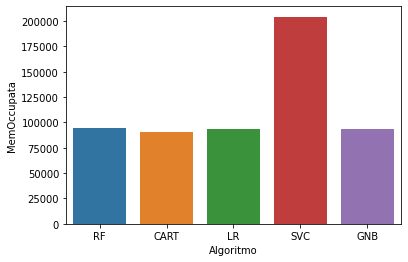

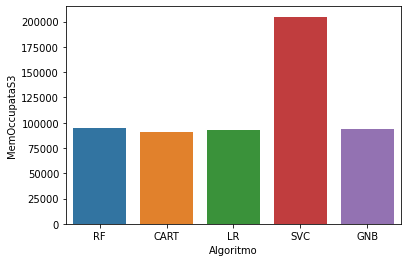

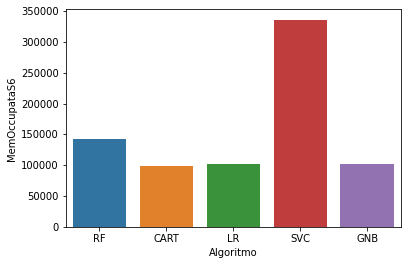

In [27]:
columns = ['MemOccupata', 'MemOccupataS3', 'MemOccupataS6']
for c in columns:   
    csv = read_csv("MemOccupationReport.csv")
    g = sbs.barplot(x=csv['Algoritmo'], y=csv[c])
    plt.ylabel(c)
    plt.show()

# Neural Network

In [30]:
def getNetwork(): 
    n = 100
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dense(np.unique(y).size * n, activation='relu'))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Cross-Validation NN

In [27]:
EPOCHS = 500
BATCH_SIZE = 8
num_folds = 10


kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_train = scaler.fit_transform(X_cross_train)
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    X_cross_test = scaler.transform(X_cross_test)
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 600)               19800     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 3606      
Total params: 24,462
Trainable params: 24,462
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
54/54 [==============================] - 0s 540us/step - loss: 1.2375 - accuracy: 0.3796
Epoch 2/500
54/54 [==============================] - 0s 565us/step - loss: 0.9130 - accuracy: 0.5069
Epoch 3/500
54/54 [==============================] - 0s 543us/step - loss: 0.6900 - accuracy: 0.6829
Epoch 4/500
54/54 [==============================] - 0s 528us/step - loss: 0

54/54 [==============================] - 0s 584us/step - loss: 0.1773 - accuracy: 0.8843
Epoch 75/500
54/54 [==============================] - 0s 574us/step - loss: 0.1791 - accuracy: 0.8727
Epoch 76/500
54/54 [==============================] - 0s 563us/step - loss: 0.1725 - accuracy: 0.9074
Epoch 77/500
54/54 [==============================] - 0s 557us/step - loss: 0.1852 - accuracy: 0.8935
Epoch 78/500
54/54 [==============================] - 0s 538us/step - loss: 0.1737 - accuracy: 0.8958
Epoch 79/500
54/54 [==============================] - 0s 538us/step - loss: 0.1761 - accuracy: 0.8935
Epoch 80/500
54/54 [==============================] - 0s 595us/step - loss: 0.1801 - accuracy: 0.8958
Epoch 81/500
54/54 [==============================] - 0s 561us/step - loss: 0.1775 - accuracy: 0.8912
Epoch 82/500
54/54 [==============================] - 0s 568us/step - loss: 0.1730 - accuracy: 0.9167
Epoch 83/500
54/54 [==============================] - 0s 582us/step - loss: 0.1712 - accuracy: 

KeyboardInterrupt: 

# Train and Test

In [33]:
EPOCHS = 500 if choosenIndex == 0 else 1000
BATCH_SIZE = 8

model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
report = classification_report(y_test, pred)
classification_report_csv(report, "NN")
print(report)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 600)               19800     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 3606      
Total params: 24,462
Trainable params: 24,462
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
45/45 [==============================] - 0s 2ms/step - loss: 344.7297 - accuracy: 0.1639 - val_loss: 190.3006 - val_accuracy: 0.1417
Epoch 2/500
45/45 [==============================] - 0s 685us/step - loss: 172.5504 - accuracy: 0.1750 - val_loss: 154.4430 - val_accuracy: 0.1583
Epoch 3/500
45/45 [==============================] - 0s 734us/step - loss: 102.8222 - a

45/45 [==============================] - 0s 680us/step - loss: 1.2167 - accuracy: 0.4806 - val_loss: 1.1447 - val_accuracy: 0.5167
Epoch 53/500
45/45 [==============================] - 0s 727us/step - loss: 1.1436 - accuracy: 0.4833 - val_loss: 1.0428 - val_accuracy: 0.5500
Epoch 54/500
45/45 [==============================] - 0s 701us/step - loss: 1.6474 - accuracy: 0.4167 - val_loss: 2.1680 - val_accuracy: 0.3667
Epoch 55/500
45/45 [==============================] - 0s 676us/step - loss: 1.5665 - accuracy: 0.4056 - val_loss: 1.4858 - val_accuracy: 0.4750
Epoch 56/500
45/45 [==============================] - 0s 689us/step - loss: 1.3417 - accuracy: 0.4444 - val_loss: 1.2159 - val_accuracy: 0.5083
Epoch 57/500
45/45 [==============================] - 0s 717us/step - loss: 1.2243 - accuracy: 0.5000 - val_loss: 1.4369 - val_accuracy: 0.3833
Epoch 58/500
45/45 [==============================] - 0s 858us/step - loss: 1.2821 - accuracy: 0.4444 - val_loss: 1.2665 - val_accuracy: 0.4500
Epoch

Epoch 109/500
45/45 [==============================] - 0s 635us/step - loss: 1.1107 - accuracy: 0.4778 - val_loss: 0.9968 - val_accuracy: 0.6917
Epoch 110/500
45/45 [==============================] - 0s 662us/step - loss: 1.0284 - accuracy: 0.5556 - val_loss: 1.2884 - val_accuracy: 0.4500
Epoch 111/500
45/45 [==============================] - 0s 642us/step - loss: 1.1405 - accuracy: 0.5028 - val_loss: 1.0285 - val_accuracy: 0.4417
Epoch 112/500
45/45 [==============================] - 0s 635us/step - loss: 1.1477 - accuracy: 0.4806 - val_loss: 1.0821 - val_accuracy: 0.4333
Epoch 113/500
45/45 [==============================] - 0s 640us/step - loss: 1.0092 - accuracy: 0.5833 - val_loss: 0.9799 - val_accuracy: 0.7333
Epoch 114/500
45/45 [==============================] - 0s 654us/step - loss: 1.0462 - accuracy: 0.5222 - val_loss: 0.9449 - val_accuracy: 0.6333
Epoch 115/500
45/45 [==============================] - 0s 653us/step - loss: 1.0662 - accuracy: 0.4944 - val_loss: 0.9613 - val_ac

45/45 [==============================] - 0s 627us/step - loss: 0.9476 - accuracy: 0.5778 - val_loss: 0.9175 - val_accuracy: 0.5750
Epoch 166/500
45/45 [==============================] - 0s 657us/step - loss: 1.1312 - accuracy: 0.5361 - val_loss: 1.0088 - val_accuracy: 0.4750
Epoch 167/500
45/45 [==============================] - 0s 651us/step - loss: 0.9645 - accuracy: 0.5278 - val_loss: 0.8553 - val_accuracy: 0.6667
Epoch 168/500
45/45 [==============================] - 0s 638us/step - loss: 1.0797 - accuracy: 0.4806 - val_loss: 0.8690 - val_accuracy: 0.7583
Epoch 169/500
45/45 [==============================] - 0s 631us/step - loss: 1.0464 - accuracy: 0.4972 - val_loss: 0.8728 - val_accuracy: 0.5917
Epoch 170/500
45/45 [==============================] - 0s 645us/step - loss: 0.9327 - accuracy: 0.5750 - val_loss: 0.8040 - val_accuracy: 0.7000
Epoch 171/500
45/45 [==============================] - 0s 635us/step - loss: 1.0368 - accuracy: 0.5194 - val_loss: 1.0897 - val_accuracy: 0.5917

45/45 [==============================] - 0s 656us/step - loss: 0.9157 - accuracy: 0.5889 - val_loss: 0.9042 - val_accuracy: 0.5500
Epoch 222/500
45/45 [==============================] - 0s 639us/step - loss: 0.9589 - accuracy: 0.5556 - val_loss: 0.7759 - val_accuracy: 0.6667
Epoch 223/500
45/45 [==============================] - 0s 824us/step - loss: 0.8904 - accuracy: 0.5889 - val_loss: 0.7558 - val_accuracy: 0.6333
Epoch 224/500
45/45 [==============================] - 0s 670us/step - loss: 1.0016 - accuracy: 0.5278 - val_loss: 0.9539 - val_accuracy: 0.5333
Epoch 225/500
45/45 [==============================] - 0s 653us/step - loss: 0.9952 - accuracy: 0.5333 - val_loss: 0.9152 - val_accuracy: 0.6500
Epoch 226/500
45/45 [==============================] - 0s 632us/step - loss: 0.9985 - accuracy: 0.5833 - val_loss: 1.7665 - val_accuracy: 0.3167
Epoch 227/500
45/45 [==============================] - 0s 656us/step - loss: 1.0735 - accuracy: 0.5583 - val_loss: 0.7246 - val_accuracy: 0.7417

45/45 [==============================] - 0s 641us/step - loss: 0.8155 - accuracy: 0.6222 - val_loss: 0.7493 - val_accuracy: 0.7583
Epoch 278/500
45/45 [==============================] - 0s 636us/step - loss: 0.7323 - accuracy: 0.6833 - val_loss: 0.5490 - val_accuracy: 0.8167
Epoch 279/500
45/45 [==============================] - 0s 623us/step - loss: 0.8223 - accuracy: 0.6389 - val_loss: 0.9563 - val_accuracy: 0.4833
Epoch 280/500
45/45 [==============================] - 0s 669us/step - loss: 0.7696 - accuracy: 0.6944 - val_loss: 0.6545 - val_accuracy: 0.7250
Epoch 281/500
45/45 [==============================] - 0s 661us/step - loss: 0.7533 - accuracy: 0.6861 - val_loss: 0.8052 - val_accuracy: 0.5333
Epoch 282/500
45/45 [==============================] - 0s 640us/step - loss: 0.7526 - accuracy: 0.6361 - val_loss: 0.7672 - val_accuracy: 0.6417
Epoch 283/500
45/45 [==============================] - 0s 635us/step - loss: 0.8653 - accuracy: 0.6250 - val_loss: 0.7874 - val_accuracy: 0.5833

45/45 [==============================] - 0s 627us/step - loss: 0.4775 - accuracy: 0.8083 - val_loss: 0.5144 - val_accuracy: 0.7333
Epoch 334/500
45/45 [==============================] - 0s 669us/step - loss: 0.5345 - accuracy: 0.7667 - val_loss: 0.4727 - val_accuracy: 0.7750
Epoch 335/500
45/45 [==============================] - 0s 658us/step - loss: 0.6349 - accuracy: 0.6944 - val_loss: 0.5544 - val_accuracy: 0.6833
Epoch 336/500
45/45 [==============================] - 0s 668us/step - loss: 0.5953 - accuracy: 0.7639 - val_loss: 0.4115 - val_accuracy: 0.9000
Epoch 337/500
45/45 [==============================] - 0s 646us/step - loss: 0.4631 - accuracy: 0.8333 - val_loss: 0.4595 - val_accuracy: 0.7417
Epoch 338/500
45/45 [==============================] - 0s 614us/step - loss: 0.6909 - accuracy: 0.6833 - val_loss: 0.6077 - val_accuracy: 0.6333
Epoch 339/500
45/45 [==============================] - 0s 650us/step - loss: 0.5418 - accuracy: 0.7417 - val_loss: 0.4711 - val_accuracy: 0.9167

45/45 [==============================] - 0s 644us/step - loss: 0.5730 - accuracy: 0.7694 - val_loss: 0.4274 - val_accuracy: 0.7917
Epoch 390/500
45/45 [==============================] - 0s 643us/step - loss: 0.6113 - accuracy: 0.6972 - val_loss: 0.5165 - val_accuracy: 0.7167
Epoch 391/500
45/45 [==============================] - 0s 622us/step - loss: 0.5380 - accuracy: 0.7222 - val_loss: 0.3758 - val_accuracy: 0.7917
Epoch 392/500
45/45 [==============================] - 0s 660us/step - loss: 0.4449 - accuracy: 0.8111 - val_loss: 0.3515 - val_accuracy: 0.9167
Epoch 393/500
45/45 [==============================] - 0s 636us/step - loss: 0.4320 - accuracy: 0.8194 - val_loss: 0.5287 - val_accuracy: 0.6500
Epoch 394/500
45/45 [==============================] - 0s 664us/step - loss: 0.4185 - accuracy: 0.8444 - val_loss: 0.5782 - val_accuracy: 0.6750
Epoch 395/500
45/45 [==============================] - 0s 640us/step - loss: 0.5666 - accuracy: 0.7306 - val_loss: 0.3392 - val_accuracy: 0.9750

45/45 [==============================] - 0s 633us/step - loss: 0.4040 - accuracy: 0.8444 - val_loss: 0.3026 - val_accuracy: 0.9833
Epoch 446/500
45/45 [==============================] - 0s 666us/step - loss: 0.4251 - accuracy: 0.7778 - val_loss: 0.3096 - val_accuracy: 0.9667
Epoch 447/500
45/45 [==============================] - 0s 645us/step - loss: 0.4051 - accuracy: 0.8167 - val_loss: 0.3297 - val_accuracy: 0.8250
Epoch 448/500
45/45 [==============================] - 0s 646us/step - loss: 0.7589 - accuracy: 0.6389 - val_loss: 0.7710 - val_accuracy: 0.6000
Epoch 449/500
45/45 [==============================] - 0s 621us/step - loss: 0.5376 - accuracy: 0.7639 - val_loss: 0.3097 - val_accuracy: 0.9750
Epoch 450/500
45/45 [==============================] - 0s 649us/step - loss: 0.4783 - accuracy: 0.7722 - val_loss: 0.6154 - val_accuracy: 0.6500
Epoch 451/500
45/45 [==============================] - 0s 639us/step - loss: 0.4628 - accuracy: 0.7694 - val_loss: 0.3007 - val_accuracy: 0.9750

# Export Models in C code

In [34]:

# Neural network with TinyMLGen
with open(tasks[choosenIndex] + '/exportedModels/' + 'NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=True))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[choosenIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

INFO:tensorflow:Assets written to: /tmp/tmpcdsexjp3/assets


INFO:tensorflow:Assets written to: /tmp/tmpcdsexjp3/assets
